<a href="https://colab.research.google.com/github/Orixtosius/Computer-Vision-Exercises/blob/main/Fruit_Classificiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting Data From Kaggle

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! kaggle datasets download moltean/fruits

 99% 1.27G/1.28G [00:21<00:00, 52.5MB/s]
100% 1.28G/1.28G [00:21<00:00, 65.1MB/s]


In [ ]:
! unzip fruits.zip

## Dataset Manipulations

In [6]:
import os

In [7]:
def makeDirectory(path):
  if not os.path.exists(path):
    os.mkdir(path)

def link(src, dst):
  if not os.path.exists(dst):
    os.symlink(src, dst, target_is_directory=True)

In [9]:
makeDirectory("/content/small-fruits-360-ds")

In [10]:
classes = [
  'Apple Golden 1',
  'Avocado',
  'Lemon',
  'Mango',
  'Kiwi',
  'Banana',
  'Strawberry',
  'Raspberry'
]

In [11]:
train_path_from = os.path.abspath("/content/fruits-360_dataset/fruits-360/Training")
test_path_from = os.path.abspath("/content/fruits-360_dataset/fruits-360/Test")

train_path_to = os.path.abspath("/content/small-fruits-360-ds/Training")
test_path_to = os.path.abspath("/content/small-fruits-360-ds/Test")

makeDirectory(train_path_to)
makeDirectory(test_path_to)

for c in classes:
  link(train_path_from + '/' + c, train_path_to + '/' + c)
  link(test_path_from + '/' + c, test_path_to + '/' + c)

## Model Building

In [4]:
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [26]:
IMAGE_SIZE = [100, 100]
IMAGE_SIZE_RGB = IMAGE_SIZE + [3]
EPOCHS = 5
BATCH_SIZE = 32

In [12]:
train_path = '/content/small-fruits-360-ds/Training'
test_path = '/content/small-fruits-360-ds/Test'

In [16]:
training_image_files = glob(train_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')
print(f'Training\n{training_image_files[:5]}\nTest\n{test_image_files[:5]}')

Training
['/content/small-fruits-360-ds/Training/Mango/r_301_100.jpg', '/content/small-fruits-360-ds/Training/Mango/r_324_100.jpg', '/content/small-fruits-360-ds/Training/Mango/220_100.jpg', '/content/small-fruits-360-ds/Training/Mango/96_100.jpg', '/content/small-fruits-360-ds/Training/Mango/r_76_100.jpg']
Test
['/content/small-fruits-360-ds/Test/Mango/r_323_100.jpg', '/content/small-fruits-360-ds/Test/Mango/r_266_100.jpg', '/content/small-fruits-360-ds/Test/Mango/r_245_100.jpg', '/content/small-fruits-360-ds/Test/Mango/r_212_100.jpg', '/content/small-fruits-360-ds/Test/Mango/r_322_100.jpg']


In [17]:
folders = glob(train_path + '/*')
folders

['/content/small-fruits-360-ds/Training/Mango',
 '/content/small-fruits-360-ds/Training/Kiwi',
 '/content/small-fruits-360-ds/Training/Lemon',
 '/content/small-fruits-360-ds/Training/Apple Golden 1',
 '/content/small-fruits-360-ds/Training/Strawberry',
 '/content/small-fruits-360-ds/Training/Raspberry',
 '/content/small-fruits-360-ds/Training/Banana',
 '/content/small-fruits-360-ds/Training/Avocado']

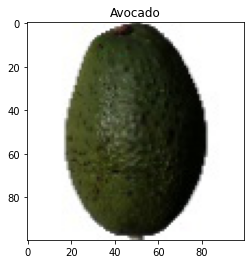

In [25]:
x = np.random.choice(training_image_files)
plt.title(x.split('/')[-2])
plt.imshow(image.load_img(x))

In [27]:
vgg = VGG16(input_shape = IMAGE_SIZE_RGB, weights='imagenet', include_top = False)

for layer in vgg.layers:
  layer.trainable = Flatten

x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation = 'softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

58900480/58889256 [==============================] - 1s 0us/step


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [29]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [30]:
gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = .1,
    height_shift_range = .1,
    shear_range = .1,
    zoom_range = .2,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input
)

In [32]:
test_gen = gen.flow_from_directory(test_path, target_size = IMAGE_SIZE)
print(test_gen.class_indices)
test_gen.class_indices.items()

Found 1285 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


dict_items([('Apple Golden 1', 0), ('Avocado', 1), ('Banana', 2), ('Kiwi', 3), ('Lemon', 4), ('Mango', 5), ('Raspberry', 6), ('Strawberry', 7)])

In [34]:
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k
labels

['Apple Golden 1',
 'Avocado',
 'Banana',
 'Kiwi',
 'Lemon',
 'Mango',
 'Raspberry',
 'Strawberry']

Min value is -104.74066925048828 and Max value is 151.06100463867188


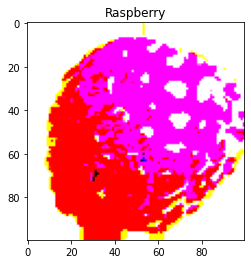

In [39]:
for x, y in test_gen:
  print(f'Min value is {x[1].min()} and Max value is {x[1].max()}')
  plt.title(labels[np.argmax(y[1])])
  plt.imshow(x[1])
  plt.show()
  break

In [41]:
train_datagen = gen.flow_from_directory(
    train_path,
    shuffle = True,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

test_datagen = gen.flow_from_directory(
    test_path,
    shuffle = True,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE
)

Found 3827 images belonging to 8 classes.
Found 1285 images belonging to 8 classes.


In [43]:
r = model.fit_generator(
    train_datagen, 
    validation_data = test_datagen,
    epochs = EPOCHS,
    steps_per_epoch = len(training_image_files) // BATCH_SIZE,
    validation_steps = len(test_image_files) // BATCH_SIZE
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
119/119 [==============================] - 1898s 16s/step - loss: 263.8493 - accuracy: 0.1989 - val_loss: 1.7985 - val_accuracy: 0.2219
Epoch 2/5
119/119 [==============================] - 1731s 15s/step - loss: 2.7521 - accuracy: 0.2640 - val_loss: 3.1304 - val_accuracy: 0.1781
Epoch 3/5
119/119 [==============================] - 1741s 15s/step - loss: 2.1064 - accuracy: 0.3903 - val_loss: 0.8697 - val_accuracy: 0.7016
Epoch 4/5
119/119 [==============================] - 1745s 15s/step - loss: 0.8460 - accuracy: 0.7652 - val_loss: 0.3248 - val_accuracy: 0.8617
Epoch 5/5
119/119 [==============================] - 1756s 15s/step - loss: 2.6450 - accuracy: 0.8253 - val_loss: 0.1842 - val_accuracy: 0.9289


In [44]:
import itertools

def get_confusion_matrix(path, N):
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(path, target_size = IMAGE_SIZE_RGB, shuffle = False, batch_size=BATCH_SIZE * 2):
    i+=1
    if not i%50:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis = 1)
    y = np.argmax(y, axis = 1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

    cm = confusion_matrix(targets, predictions)
    return cm


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

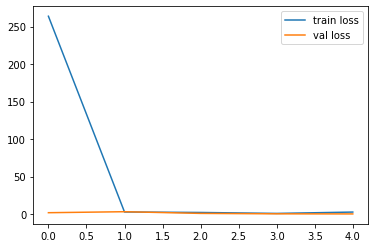

In [48]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

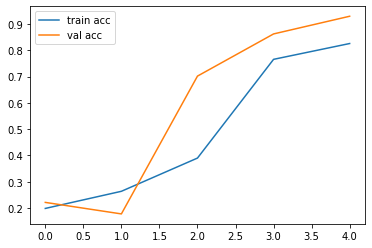

In [49]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()